In [1]:
import math
import pydicom
import numpy as np
import pandas as pd
from utils import display
from scipy import ndimage
import matplotlib.pyplot as plt

In [2]:
dicom_file_path = 'images/DICOMOBJ/BAR1'

# Read the DICOM file
dicom_data = pydicom.dcmread(dicom_file_path)
arr = dicom_data.pixel_array 
h, w = arr.shape
crop = [int(0.36*h), int(0.68*h), int(0.12*w), int(0.89*w)]
arr = dicom_data.pixel_array[crop[0]: crop[1], crop[2]: crop[3]] # crop aspect
h, w = arr.shape
h, w

(399, 949)

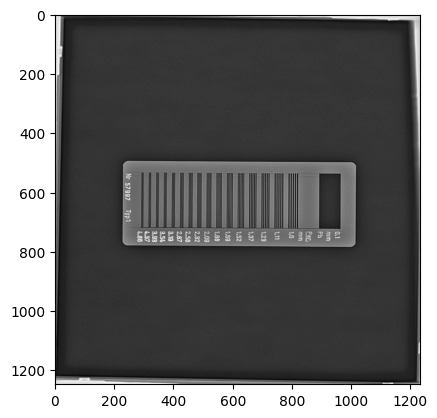

In [3]:
display(dicom_data.pixel_array, True)

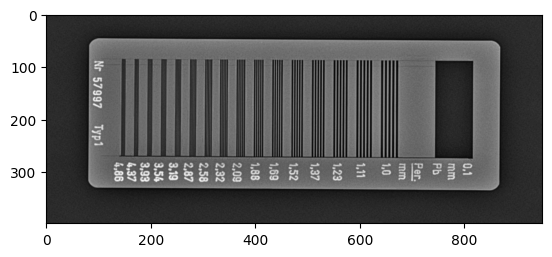

In [4]:
display(arr, True)

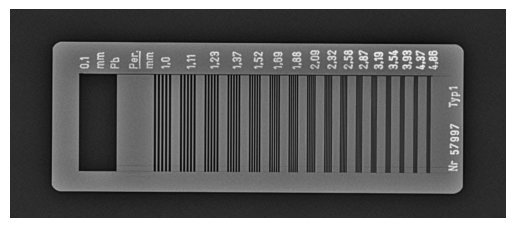

In [5]:
display(ndimage.rotate(arr, 180))

In [6]:
arr = ndimage.rotate(arr, 180)

hp = int(0.28*h)
wp = int(0.03*w)

In [7]:
focus_l = arr[h-2*hp: int(h*.95), wp*9: wp*11]
nrows, ncols = focus_l.shape
nrows, ncols

(202, 56)

In [8]:
def argdiffs(arr) :
    """ 
    find most differents position of pixel value by col
    Return: argdiff in len(col)
    """
    nrows, ncols = arr.shape
    arg_diffs = []
    for c in range(ncols) :
        max_diff = 0
        argmax_diff = 0
        for r in range(nrows) :
            # find different of past val 
            if r+1 < nrows : # index out of length
                cur_val = arr[r][c]
                next_val = arr[r+1][c]
                diff = abs(int(cur_val) - int(next_val)) # overflow
                if diff > max_diff :
                    max_diff = diff
                    argmax_diff = r
        arg_diffs.append(argmax_diff)
    return arg_diffs

In [9]:
arg_diffs = argdiffs(focus_l)
len(arg_diffs)

56

In [10]:
unique_elements, counts = np.unique(arg_diffs, return_counts=True)
unique_elements, counts

(array([171]), array([56], dtype=int64))

In [11]:
# most common argdiff
arg_diffs = argdiffs(focus_l)
unique_elements, counts = np.unique(arg_diffs, return_counts=True)
most_common_index = np.argmax(counts)
y1 = unique_elements[most_common_index]
y1

171

In [12]:
focus_r = arr[h-2*hp: int(h*.95), w-(wp*11): w-(wp*9)]
nrows, ncols = focus_r.shape
nrows, ncols

(202, 56)

In [13]:
# most common argdiff
arg_diffs = argdiffs(focus_r)
unique_elements, counts = np.unique(arg_diffs, return_counts=True)
most_common_index = np.argmax(counts)
y2 = unique_elements[most_common_index]
y2

173

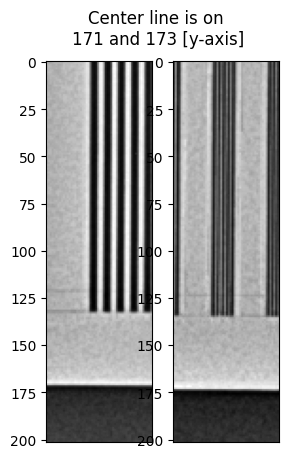

In [14]:
plt.figure(figsize=(3, 5))
plt.subplot(1, 2, 1)
display(focus_l, axis=True)
plt.tick_params(bottom=False, labelbottom=False) # hide x-axis

plt.subplot(1, 2, 2)
display(focus_r, axis=True)
plt.tick_params(bottom=False, labelbottom=False)
plt.suptitle(f"Center line is on \n{y1} and {y2} [y-axis]");

In [15]:
def find_theta(w, y1, y2) :
    """
    find theta from y1, y2
    Return: theta in degree
    """
    a = y2-y1
    theta_r = math.atan(a/w)
    theta_d = math.degrees(theta_r)
    return theta_d

In [16]:
theta = find_theta(w, y1, y2)
theta

0.12074961999434554

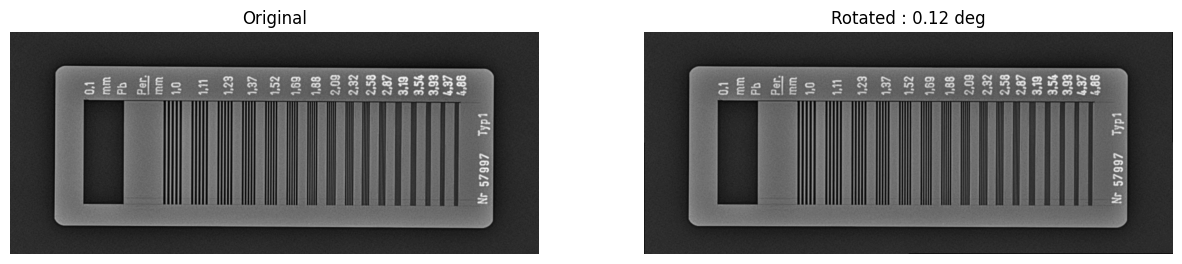

In [17]:
rotate_img = ndimage.rotate(arr, theta, reshape=False, cval=arr.min())

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("Original")
display(arr)

plt.subplot(1, 2, 2)
plt.title(f"Rotated : {theta:.2f} deg")
display(rotate_img)

In [18]:
h, w = rotate_img.shape
h, w

(399, 949)

In [19]:
hp = int(0.11*h)
wp = int(0.10*w)

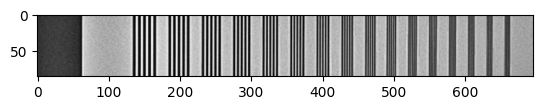

In [20]:
focus = rotate_img[h//2-hp: h//2+hp, int(wp*1.5): w-int(wp*1.2)]
display(focus, True)

In [21]:
focus.shape

(86, 696)

In [22]:
# mean by col
oneline = np.mean(focus, axis=0, dtype=np.uint32)
s = np.vstack((oneline, oneline, oneline, oneline, oneline, oneline, oneline, oneline, oneline))
display(s)

In [23]:
oneline[: 20]

array([4931, 4944, 4956, 4971, 4983, 5021, 5041, 5082, 5131, 5160, 5160,
       5135, 5180, 5233, 5248, 5221, 5237, 5277, 5293, 5286], dtype=uint32)

<img src="determined.PNG" width="800px">

In [24]:
diff_vals = []
for idx in range(len(oneline)) :
    if idx+1 < len(oneline) :
        cur_val = oneline[idx]
        next_val = oneline[idx+1]
        diff = abs(int(cur_val) - int(next_val))
        diff_vals.append(diff)

In [25]:
np.mean(diff_vals)

968.3798561151079

In [26]:
new_ts = []
for val in diff_vals :
    if val < np.mean(diff_vals) : 
        val = 0
    else : 
        val = 1000
    new_ts.append(val)

In [27]:
cut_count = int(len(new_ts)*0.015) # if zero is count more than this add it to position

In [28]:
zero_positions = [0]
is_start = False
is_start_zero = True 
start_zero_pos = None
count = 0
for idx, value in enumerate(new_ts) :
    if idx+1 == len(new_ts) : # forgot last one
        zero_positions.append(start_zero_pos)
        zero_positions.append(idx)
    
    if value == 1000 :
        if count >= cut_count :
            zero_positions.append(start_zero_pos)
            zero_positions.append(idx)
        is_start = True
        count = 0
        is_start_zero = True
    
    if is_start :
        if value == 0 :
            if is_start_zero : 
                start_zero_pos = idx
                is_start_zero = False
            count += 1

In [29]:
trim = int(0.004*len(oneline))
linepairs = [(zero_positions[i]+trim, zero_positions[i + 1]-trim) for i in range(0, len(zero_positions) - 1, 2)]
linepairs

[(2, 62),
 (135, 166),
 (185, 213),
 (232, 257),
 (276, 298),
 (317, 337),
 (356, 374),
 (393, 409),
 (428, 442),
 (461, 474),
 (491, 502),
 (521, 531),
 (551, 559),
 (579, 586),
 (605, 612),
 (632, 638),
 (657, 662)]

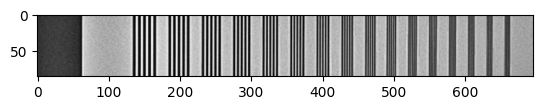

In [30]:
plt.subplot(2, 1, 1)
display(focus, True)

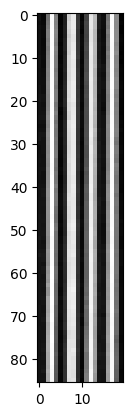

In [31]:
linepair_idx = 5
display(focus[:, linepairs[linepair_idx][0]: linepairs[linepair_idx][1]], True)

In [32]:
min_val0 = np.min(focus[:, linepairs[0][0]: linepairs[0][1]])
max_val0 = np.max(focus[:, linepairs[0][1]: linepairs[1][0]])
max_contrast = max_val0 - min_val0
min_val0, max_val0, max_contrast

(3878, 10782, 6904)

In [33]:
res = {"Linepair": [0], "Max": [max_val0], "Min": [min_val0], "Contrast": [max_contrast], "Modulation": [100]}
for idx, (s1, s2) in enumerate(linepairs[1:], start=1) :
    linepair = focus[:, s1: s2]
    mean_val_col = np.mean(linepair, axis=0)
    # sorted_val = np.sort(mean_val_col) # to seperate max and min vals
    # mid_pos = max(min((s2-s1)//2, int(.3*(s2-s1))), 1) # how to select actual value, 1 if 0
    # mean_min_vals = round(np.mean(sorted_val[: mid_pos]))
    # mean_max_vals = round(np.mean(sorted_val[-mid_pos: ]))
    min_vals = np.min(mean_val_col)
    max_vals = np.max(mean_val_col)
    contrast = max_vals-min_vals
    res["Linepair"].append(idx)
    res["Max"].append(max_vals)
    res["Min"].append(min_vals)
    res["Contrast"].append(contrast)
    res["Modulation"].append(round(contrast*100/max_contrast, 3))
res = pd.DataFrame(res)

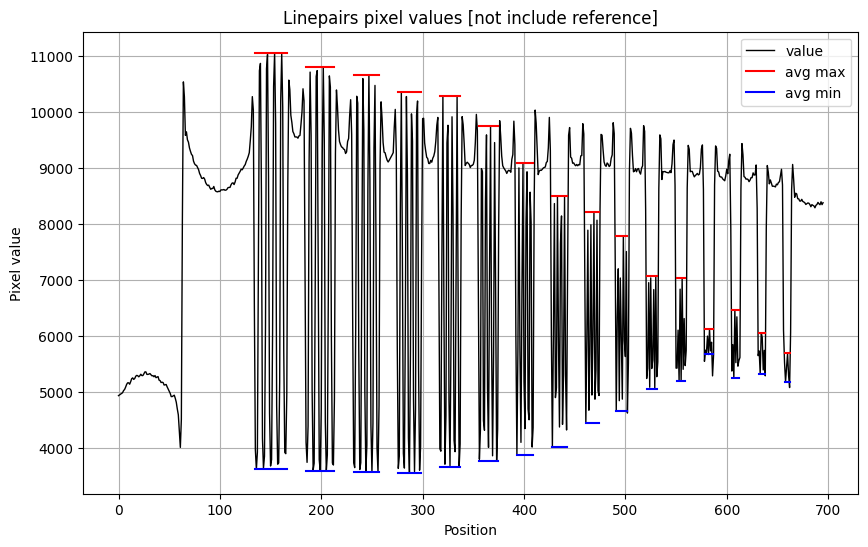

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(oneline, color="black", linewidth=1)
for (s1, s2), (_, max_v, min_v, _, _) in zip(linepairs[1:], res.values[1:]) :
    plt.plot([s1, s2], [max_v, max_v], color="red")
    plt.plot([s1, s2], [min_v, min_v], color="blue")
plt.legend(["value", "avg max", "avg min"])
plt.grid(True)
plt.title("Linepairs pixel values [not include reference]")
plt.ylabel("Pixel value")
plt.xlabel("Position");

<img src="imageJ.PNG" width="700px">

In [35]:
res

,Linepair,Max,Min,Contrast,Modulation
0,0,10782.000000,3878.000000,6904.000000,100.000
1,1,11052.837209,3617.197674,7435.639535,107.700
2,2,10799.011628,3585.220930,7213.790698,104.487
3,3,10662.488372,3562.558140,7099.930233,102.838
4,4,10348.837209,3555.453488,6793.383721,98.398
5,5,10279.686047,3656.302326,6623.383721,95.935
6,6,9737.000000,3758.790698,5978.209302,86.591
7,7,9085.476744,3871.941860,5213.534884,75.515
8,8,8487.162791,4012.604651,4474.558140,64.811
9,9,8204.709302,4438.209302,3766.500000,54.555


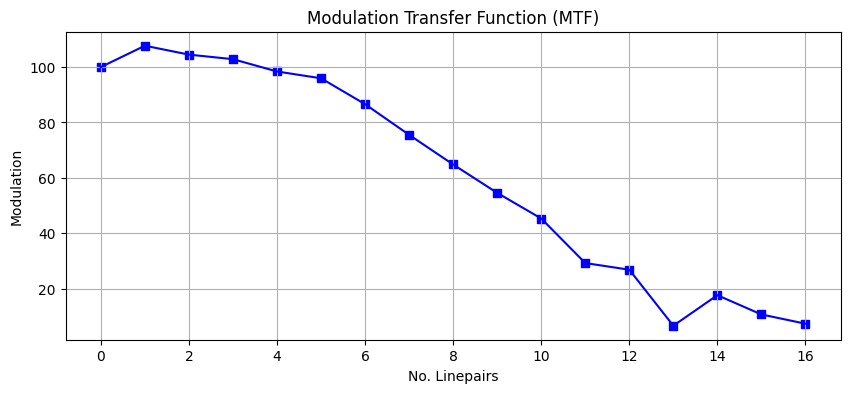

In [36]:
plt.figure(figsize=(10, 4))
plt.title("Modulation Transfer Function (MTF)")
plt.plot(res["Linepair"], res["Modulation"], color="blue")
plt.scatter(res["Linepair"], res["Modulation"], color="blue", marker="s")
plt.grid(True)
plt.ylabel("Modulation")
plt.xlabel("No. Linepairs");